# Hierarchical model: factory data with Stan 

In this project we try to implement various hierarchical Gaussian model for a quality control measurements problem.
The provided factory.txt file contains quality control measurements from 6 machines in a factory (units of the measurements are irrelevant here). Quality control measurements are expensive and time-consuming, so only 5 measurements were done for each machine. In addition to the existing machines, we also want to measure the quality of another machine (the seventh machine). 

We will use each of the three models – separate, pooled, and hierarchical – to find out:
 * the posterior distribution of the mean of the quality measurements of the sixth machine.
 * the predictive distribution for another quality measurement of the sixth machine.
 * the posterior distribution of the mean of the quality measurements of the seventh machine.


In [5]:
y = np.loadtxt('factory.txt')
print y.shape
print y
print y.mean(axis=0)
print y.std(axis=0, ddof=1)

(5, 6)
[[  83.  117.  101.  105.   79.   57.]
 [  92.  109.   93.  119.   97.   92.]
 [  92.  114.   92.  116.  103.  104.]
 [  46.  104.   86.  102.   79.   77.]
 [  67.   87.   67.  116.   92.  100.]]
[  76.   106.2   87.8  111.6   90.    86. ]
[ 17.56132113  10.57166023  11.4437756    6.77052435   9.63327566
  17.19302184]


### Separate model

$$p(\mu_i, \sigma_i|y_i) \propto N(\mu_i, \sigma_i)p(\mu_i, \sigma_i)$$
$$p(\mu_i, \sigma_i) \propto 1$$

In [4]:
data_separate = {
    'J': y.shape[0],
    'y': y[:,5]
}
code_separate = """
data {
    int<lower=1> J; // number of data points
    vector[J] y; // measurements
}
parameters {
    real mu;
    real<lower=0> sigma;
}
model {
    y ~ normal(mu, sigma);
}
generated quantities {
    real ypred;
    ypred <- normal_rng(mu, sigma);
}
"""
fit_separate = pystan.stan(model_code=code_separate, data=data_separate, 
                           iter=1000, chains=10)
params_separate = fit_separate.extract()
print fit_separate

Inference for Stan model: anon_model_637064ccc7fb39ed95754fc8e799424b.
10 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=5000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     86.34    0.52  15.26  57.32   78.5  85.81  93.66 118.04  868.0    1.0
sigma  29.84    0.64  18.05  12.41  19.14   25.2  34.82  74.89  784.0    1.0
ypred  86.19    0.98  37.24   15.5  67.73  86.28 104.22 159.62 1445.0    1.0
lp__  -15.11    0.05    1.2  -18.2 -15.66 -14.74 -14.22 -13.86  691.0    1.0

Samples were drawn using NUTS(diag_e) at Wed Mar  9 14:26:04 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


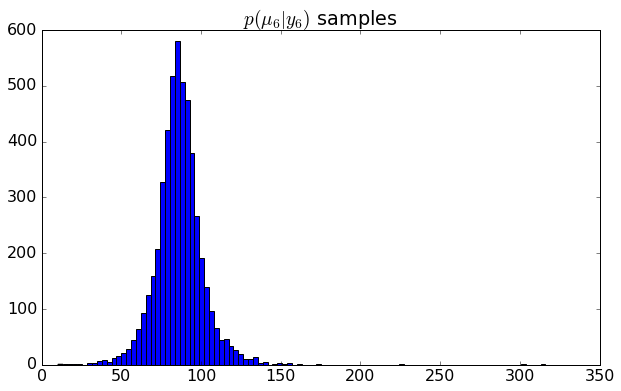

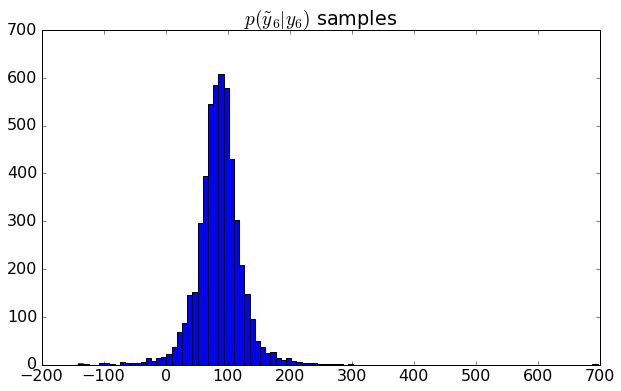

In [44]:
plt.figure(figsize=(10, 6))
plt.title(r'$p(\mu_6|y_6)$ samples')
_=plt.hist(params_separate['mu'], bins=100)

plt.figure(figsize=(10, 6))
plt.title(r'$p(\tilde{y}_6|y_6)$ samples')
_=plt.hist(params_separate['ypred'], bins=100)
plt.show()

### Pooled model

$$p(\mu, \sigma|y) \propto N(\mu, \sigma)p(\mu, \sigma)$$
$$p(\mu, \sigma) \propto 1$$

In [15]:
data_pooled = {
    'J': y.size,
    'y': y.flatten()
}
code_pooled = code_separate

fit_pooled = pystan.stan(model_code=code_pooled, data=data_pooled,
                         iter=1000, chains=10)
params_pooled = fit_pooled.extract()
print fit_pooled

Inference for Stan model: anon_model_637064ccc7fb39ed95754fc8e799424b.
10 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=5000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      92.9     0.1   3.53  85.79  90.61   92.9  95.24  99.82 1208.0    1.0
sigma   18.9    0.08   2.64  14.56  17.06  18.56   20.4  24.81 1196.0    1.0
ypred  92.95    0.48  19.54  54.22  80.08  93.03 106.11 131.44 1669.0    1.0
lp__  -99.38    0.04   1.07 -102.1  -99.8 -99.03 -98.61 -98.35  928.0    1.0

Samples were drawn using NUTS(diag_e) at Wed Mar  9 14:32:52 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


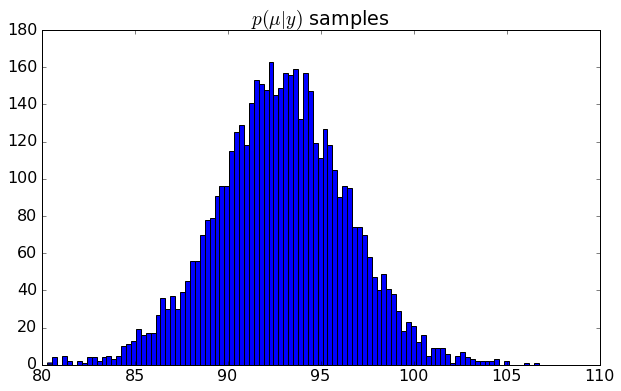

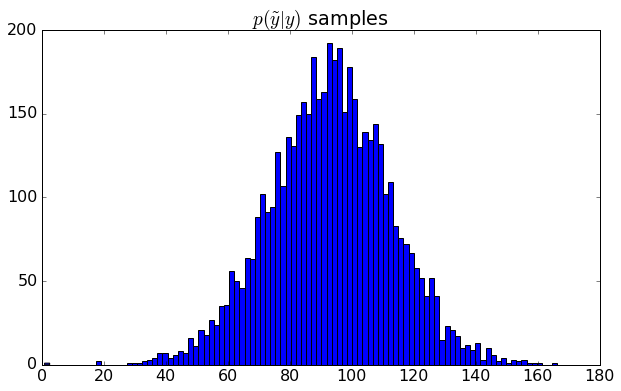

In [16]:
plt.figure(figsize=(10, 6))
plt.title(r'$p(\mu|y)$ samples')
_=plt.hist(params_pooled['mu'], bins=100)

plt.figure(figsize=(10, 6))
plt.title(r'$p(\tilde{y}|y)$ samples')
_=plt.hist(params_pooled['ypred'], bins=100)
plt.show()

### Hierarchical model

$$ p(\mu, \sigma, \mu_0, \sigma_0 | y) \propto p(y|\mu, \sigma) p(\mu|\mu_0, \sigma_0) p(\mu_0, \sigma_0) $$
$$ p(y|\mu, \sigma) = N(\mu, \sigma)$$
$$ p(\mu|\mu_0, \sigma_0) = N(\mu_0, \sigma_0) $$
$$ p(\mu_0, \sigma_0, \sigma) \propto 1 $$


In [46]:
data_hierarchical = {
    'J': y.shape[0],
    'K': y.shape[1],
    'y': y
}
code_hierarchical = """
data {
    int<lower=1> J; // number of data points
    int<lower=1> K; // number of groups 
    matrix[J,K]  y; // measurements
}
parameters {
    real          mu0;
    real<lower=0> sigma0;
    vector[K]     mu;     // group means
    real<lower=0> sigma;  // shared std
}
model {
    for (k in 1:K){
      mu[k] ~ normal(mu0, sigma0);
      y[:,k] ~ normal(mu[k], sigma);    
    }
}
generated quantities {
    real mupred;
    vector[K] ypred;

    mupred <- normal_rng(mu0, sigma0);
    for (k in 1:K)
      ypred[k] <- normal_rng(mu[k], sigma);
}
"""
fit_hierarchical = pystan.stan(model_code=code_hierarchical, 
                               data=data_hierarchical, iter=3000, chains=20)
params_hierarchical = fit_hierarchical.extract()
print fit_hierarchical

Inference for Stan model: anon_model_8c79179503378489b4e233029d799c2a.
20 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=30000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu0       92.91     0.1   7.99   76.7  88.57  92.93  97.33 109.19 6372.0    1.0
sigma0    16.18    0.15   9.71   4.22  10.18  14.08  19.53  40.92 4446.0    1.0
mu[0]     79.98     0.1    6.9  66.57  75.36  79.87  84.53  93.88 4545.0    1.0
mu[1]    103.11    0.09   6.59  90.01  98.67 103.17 107.56 116.05 5019.0    1.0
mu[2]     88.98    0.07   6.15  76.76  84.92  89.02  93.02 101.03 7743.0    1.0
mu[3]    107.25    0.12   7.07  92.84 102.58 107.37 111.99 120.97 3661.0    1.0
mu[4]      90.7    0.07   6.13  78.56  86.74  90.65  94.73 102.82 7848.0    1.0
mu[5]     87.64    0.08   6.29  75.18  83.57  87.61  91.83 100.04 7003.0    1.0
sigma     15.26    0.03    2.4  11.37  13.54  14.98  16.66  20.68 5618.0    1.0
mupred   

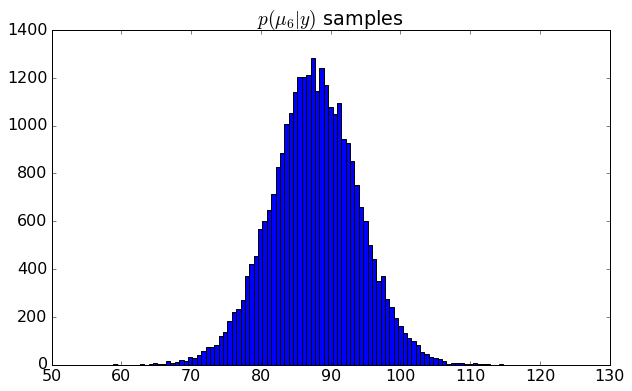

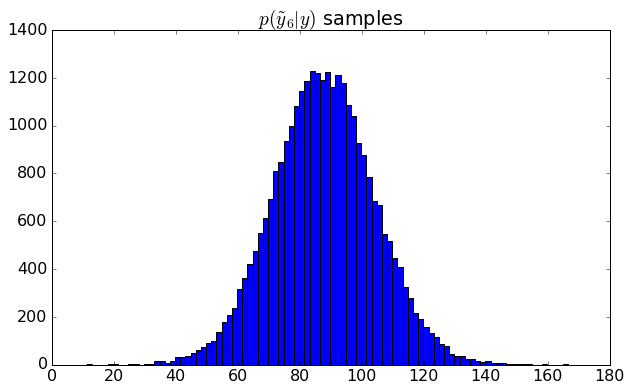

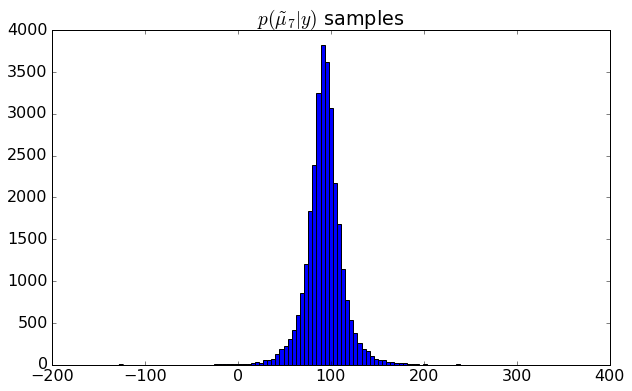

In [48]:
plt.figure(figsize=(10, 6))
plt.title(r'$p(\mu_6|y)$ samples')
_=plt.hist(params_hierarchical['mu'][:,5], bins=100)

plt.figure(figsize=(10, 6))
plt.title(r'$p(\tilde{y}_6|y)$ samples')
_=plt.hist(params_hierarchical['ypred'][:,5], bins=100)

plt.figure(figsize=(10, 6))
plt.title(r'$p(\tilde{\mu}_7|y)$ samples')
_=plt.hist(params_hierarchical['mupred'], bins=100)

plt.show()